In [2]:
list(map(lambda x: x**2, [1, 2, 3]))

[1, 4, 9]

In [5]:
from functools import reduce

In [6]:
reduce(lambda x, y: x+y, [1,2,3])

6

In [7]:
reduce(lambda x, y: x+y, map(lambda x: x**2, [1, 2, 3]))

14

In [9]:
from pyspark.sql import SparkSession

In [10]:
spark = SparkSession.builder\
 .appName('Foo')\
 .getOrCreate()

In [11]:
path = '../ml-society-science/data/movie-lens/'

In [12]:
ratings = spark.read.load(path + 'ratings.csv', format='csv', header=True, inferSchema=True)

In [13]:
ratings.printSchema()

root
 |-- userId: integer (nullable = true)
 |-- movieId: integer (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



In [14]:
ratings.show(5)

+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|     31|   2.5|1260759144|
|     1|   1029|   3.0|1260759179|
|     1|   1061|   3.0|1260759182|
|     1|   1129|   2.0|1260759185|
|     1|   1172|   4.0|1260759205|
+------+-------+------+----------+
only showing top 5 rows



In [15]:
ratings.select(ratings['rating'] > 2.5, ratings['userId'] + 1).show(5)

+--------------+------------+
|(rating > 2.5)|(userId + 1)|
+--------------+------------+
|         false|           2|
|          true|           2|
|          true|           2|
|         false|           2|
|          true|           2|
+--------------+------------+
only showing top 5 rows



In [16]:
ratings.select(ratings['rating']).agg({'rating': 'avg'}).show()

+-----------------+
|      avg(rating)|
+-----------------+
|3.543608255669773|
+-----------------+



In [17]:
ratings.select(ratings['rating']).agg({'rating': 'min'}).show()

+-----------+
|min(rating)|
+-----------+
|        0.5|
+-----------+



In [18]:
ratings.select(ratings['rating']).agg({'rating': 'max'}).show()

+-----------+
|max(rating)|
+-----------+
|        5.0|
+-----------+



In [21]:
df = ratings.groupby('userId').agg({'rating': 'avg'}).toPandas()

In [22]:
%matplotlib inline

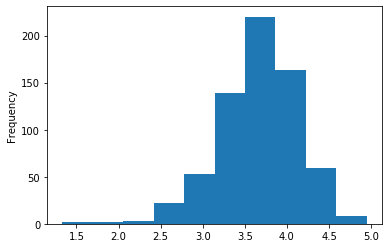

In [23]:
df['avg(rating)'].plot.hist()

In [27]:
ratings.rdd.take(5)

[Row(userId=1, movieId=31, rating=2.5, timestamp=1260759144),
 Row(userId=1, movieId=1029, rating=3.0, timestamp=1260759179),
 Row(userId=1, movieId=1061, rating=3.0, timestamp=1260759182),
 Row(userId=1, movieId=1129, rating=2.0, timestamp=1260759185),
 Row(userId=1, movieId=1172, rating=4.0, timestamp=1260759205)]

In [28]:
trainings, test = ratings.randomSplit([0.8, 0.2])

In [29]:
from pyspark.ml.recommendation import ALS

In [30]:
als = ALS(maxIter=5, regParam=0.1, userCol='userId', itemCol='movieId', ratingCol='rating', coldStartStrategy='drop')

In [33]:
model = als.fit(trainings)

In [34]:
model.recommendForAllUsers(10).show(5)

+------+--------------------+
|userId|     recommendations|
+------+--------------------+
|   471|[[108583, 5.07902...|
|   463|[[67504, 4.878709...|
|   496|[[1352, 5.6125374...|
|   148|[[67504, 5.502698...|
|   540|[[2563, 5.7589707...|
+------+--------------------+
only showing top 5 rows



In [35]:
pred = model.transform(test)

In [36]:
pred.show(5)

+------+-------+------+----------+----------+
|userId|movieId|rating| timestamp|prediction|
+------+-------+------+----------+----------+
|   380|    463|   3.0| 968949106| 2.8844426|
|   440|    471|   3.0| 835337519| 3.6980734|
|   292|    471|   3.5|1140049920|  3.775751|
|   491|    471|   3.0| 940797129| 3.5127416|
|   452|    471|   3.0| 976422396| 3.2856274|
+------+-------+------+----------+----------+
only showing top 5 rows



In [37]:
pred.select((pred['rating'] - pred['prediction'])**2).show(5)

+-------------------------------+
|POWER((rating - prediction), 2)|
+-------------------------------+
|           0.013353520130806373|
|            0.48730645384148374|
|            0.07603867681245902|
|            0.26290391320094386|
|            0.08158299170099781|
+-------------------------------+
only showing top 5 rows



In [39]:
pred.select((pred['rating'] - pred['prediction'])**2).agg({'POWER((rating - prediction), 2)': 'avg'}).collect()

[Row(avg(POWER((rating - prediction), 2))=0.8446941603591729)]

In [40]:
from pyspark.ml.evaluation import RegressionEvaluator

In [42]:
ev = RegressionEvaluator(metricName='rmse', labelCol='rating', predictionCol='prediction')

In [43]:
rmse = ev.evaluate(pred)

In [44]:
str(rmse)

'0.919072445653319'